In [3]:

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, TrajectoryIMFReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

-0.14849242404917495 -0.14849242404917498 0.2757716446627535


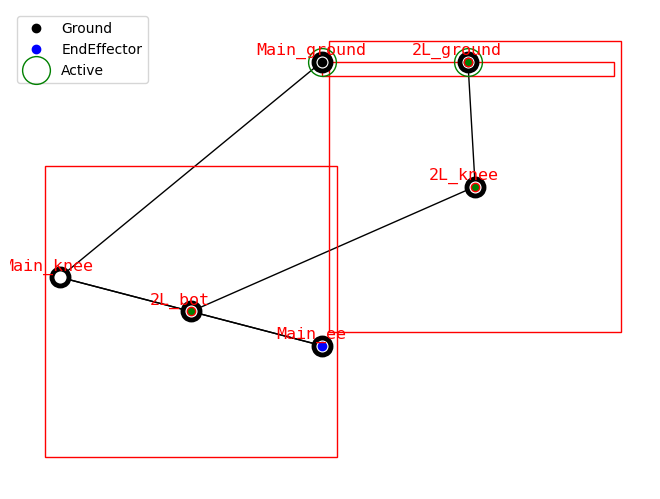

In [4]:
anlge = np.deg2rad(-45)
l1 = 0.21
l2 = 0.18

x_knee = l1 * np.sin(anlge)
y_knee = -l1 * np.cos(anlge)

y_ee = -y_knee + l2 * np.cos(anlge)
print(x_knee, y_knee, y_ee)

generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(-0.148, shift=-0.10)
graph, constrain_dict = all_graphs[0]

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

In [12]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass()
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ),
    "IMF": ImfCompute(ImfProjections.Z),
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)


# activate multiprocessing
# N_PROCESS = 16
# pool = multiprocessing.Pool(N_PROCESS)
# runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

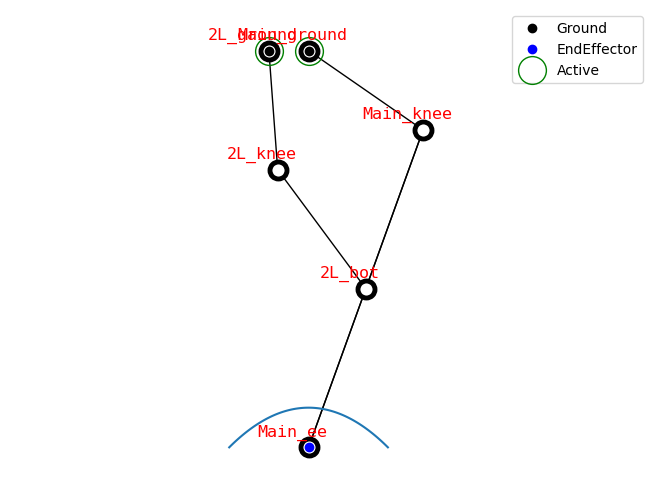

In [18]:
# central_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-1, 0.4, 0, 50))
step = convert_x_y_to_6d_traj_xz(
    *create_simple_step_trajectory([-0.2,-1],0.1,0.4))

acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [central_vertical])
reward_manager = RewardManager(crag=crag)
# reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(step, 0)
reward_manager.add_reward(acceleration_capability, 0, 1)

draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.show()

In [ ]:

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                             Actuator = actuator)
                                            # elementwise_runner=runner,

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

acceleration_capability_weight = 1/(-best_reward.item())

In [5]:
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1, 0.4, 0, 50))

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [central_vertical])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(central_vertical, 0)
reward_manager.add_reward(heavy_lifting, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

heavy_lifting_weight = 1/(-best_reward.item())

Best reward in : [25.91667548]


In [6]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))

acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_reward(acceleration_capability, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

acceleration_capability_weight_step = 1/(-best_reward.item())

Best reward in : [20.12674274]


In [7]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))

trajectory_imf = TrajectoryIMFReward(imf_key='IMF', trajectory_key="traj_6d", error_key="error")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_reward(trajectory_imf, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

trajectory_imf_weight_step = 1/(-best_reward.item())

Best reward in : [0.58971506]


In [8]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1, 0.4, 0, 50))

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")

soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step, central_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 1)
reward_manager.add_reward(acceleration_capability, 0, acceleration_capability_weight_step)
reward_manager.add_reward(trajectory_imf, 0, trajectory_imf_weight_step)
reward_manager.add_reward(acceleration_capability, 1, acceleration_capability_weight)
reward_manager.add_reward(heavy_lifting, 1, heavy_lifting_weight)

In [9]:
population_size = 32
n_generations = 100

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "st_acc_imf_v_acc_hl_generator_2", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed":1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -5.713502E-01 | -1.261252E+00
     2 |       64 | -5.1E-02 |       3 |  0.3687 |  2.00000 |  2.02224 | -8.384466E-01 | -1.610021E+00
     3 |       96 |  0.08953 |       3 |  0.4569 |  1.98908 |  2.02896 | -1.134099E+00 | -1.716425E+00
     4 |      128 | -7.2E-03 |       3 |  0.3955 |  1.98063 |  2.04835 | -1.458037E+00 | -2.017587E+00
     5 |      160 |  0.00324 |       3 |  0.4020 |  1.96689 |  2.05560 | -1.560201E+00 | -2.017587E+00
     6 |      192 | -1.1E-02 |       3 |  0.3934 |  1.95686 |  2.07085 | -1.677750E+00 | -2.112694E+00
     7 |      224 | -8.6E-03 |       3 |  0.3947 |  1.94450 |  2.08199 | -1.772177E+00 | -2.198708E+00
     8 |      256 | -2.1E-02 |       3 |  0.3871 |  1.93273 |  2.08895 | -1.872476E+00 | -2.312082E+00
     9 |      288 |  0.00822 |       3 |  0.4051 |  1.92357 |  2.09814 | 

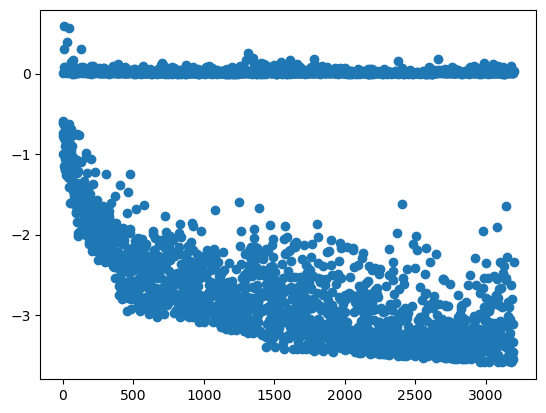

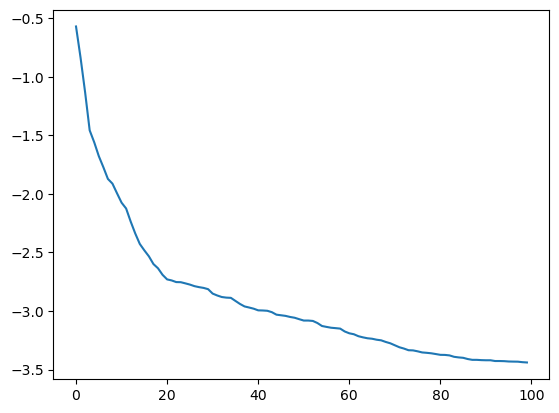

In [10]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

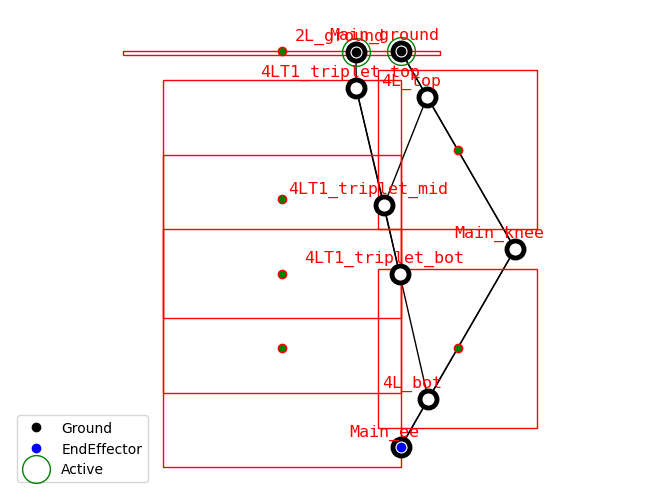

In [11]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)

In [12]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        , 29.06670108,  0.41815731],
       [ 1.        , 52.90726375,  8.46088638]])

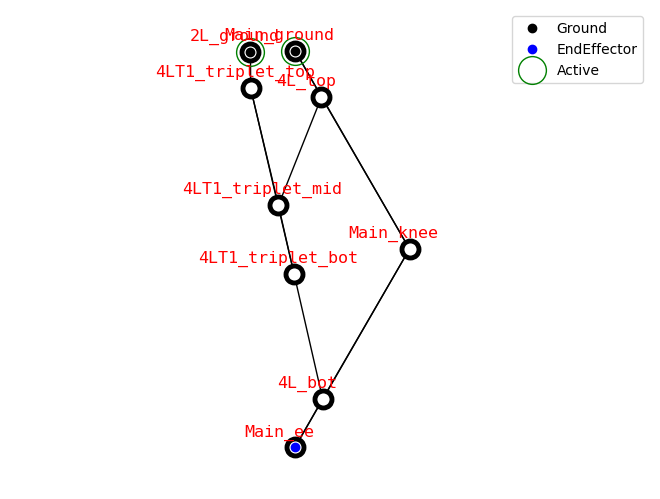

In [13]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

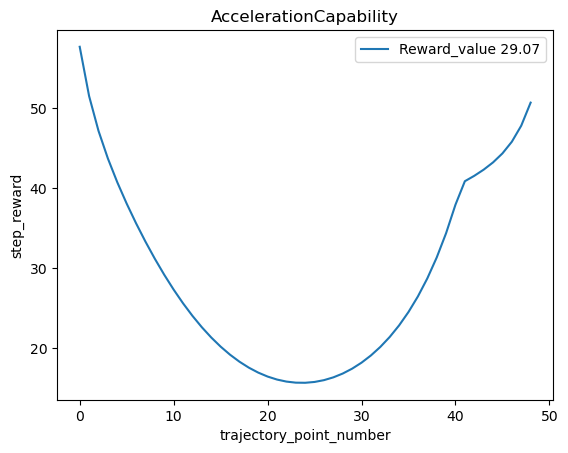

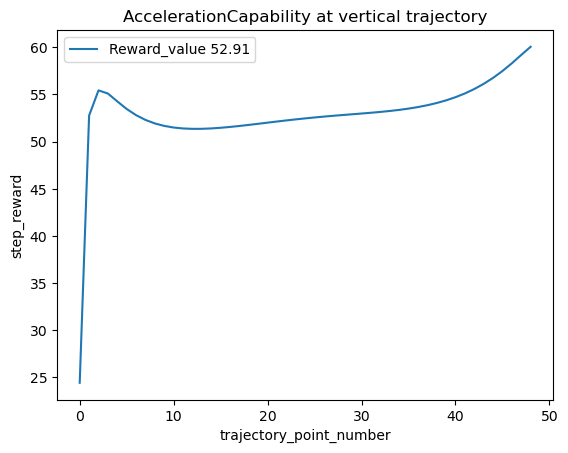

8.460886379341632


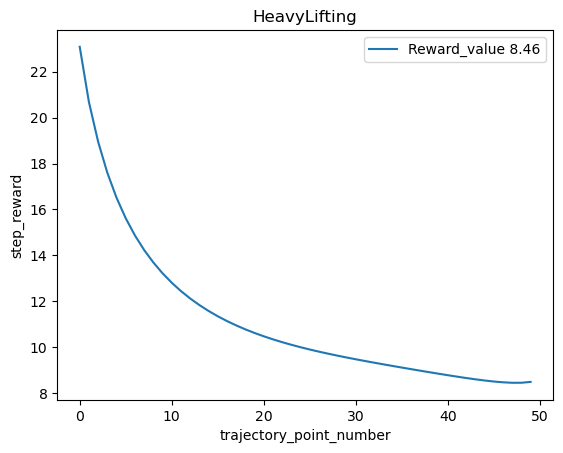

In [14]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[1]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability at vertical trajectory')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()


fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
print(reward)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

In [15]:
problem.mutate_JP_by_xopt(best_x)
final_x = problem.convert_joints2x_opt()[0].copy()

initial_x = problem.initial_xopt

difference_x = final_x - initial_x
print(initial_x)
res = np.zeros(100)
res_1 = np.zeros(100)
res_2 = np.zeros(100)
res_3 = np.zeros(100)
for i in range(100):
    additional_x = difference_x*(0.01+i/100)
    # additional_x[0] =i*0.1*0.3*0.1 
    # additional_x[4] =i*0.1*0.3*0.1
    
    current_x = initial_x + additional_x
    #print(current_x)
    problem.mutate_JP_by_xopt(current_x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    #draw_joint_point(problem.graph)

    trajectory = ground_symmetric_step
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res[i] = reward*acceleration_capability_weight_step
    reward, reward_list = trajectory_imf.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res_1[i] = reward*trajectory_imf_weight_step

    trajectory = central_vertical
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res_2[i] = reward*heavy_lifting_weight
    reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res_3[i] = reward*acceleration_capability_weight


[-0.3         0.          0.14433757 -0.25        0.14433757 -0.75
 -0.3        -0.75       -0.3        -0.375      -0.3        -0.5625    ]


ValueError: All points should be reachable to calculate a reward [0.00075733]

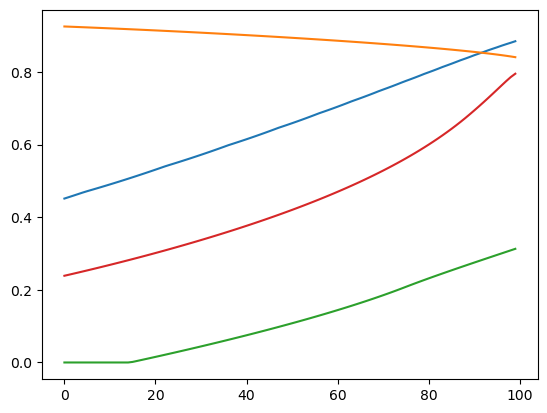

In [ ]:
plt.plot(res)
#plt.show()
plt.plot(res_1)
#plt.show()
plt.plot(res_2)
#plt.show()
plt.plot(res_3)
plt.show()

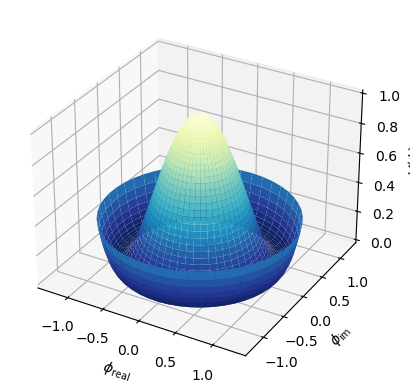

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0, 1.25, 50)
p = np.linspace(0, 2*np.pi, 50)
R, P = np.meshgrid(r, p)
Z = ((R**2 - 1)**2)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi)$')

plt.show()

In [3]:
X.shape, Y.shape, Z.shape

((50, 50), (50, 50), (50, 50))